In [ ]:
import sys
sys.path.append('..')
sys.path.append('../Libraries/')
import pclpy
import ARUSTUFF
import Plane
import Corners
import cv2
import imp
import glob
import os
import numpy as np
import pcl
import open3d
import pdal
from Plane import tic,toc
import segTree
import pandas as pd

Load cloud

In [53]:
tic()
mm = pclpy.pcl.PointCloud.PointXYZRGB()
#pclpy.pcl.io.loadPCDFile('../../Data/NistClouds/downsampledNistBetter.pcd',mm)
pclpy.pcl.io.loadPCDFile('downsampledNistBetter.pcd',mm)
#pclpy.pcl.io.loadPCDFile('fullCloudSFM.pcd',mm)
toc()

1.1441500999999334

Load landmark cylindars

In [13]:
position1 = np.array([-2.75,-6.,-22.8,0,0,1,0.2])
position2 = np.array([9.5,-34,-23.2,0,0,1,0.2])
position3 = np.array([24.5,6.5,-20.5,0,0,1,0.2])

cil1 = Corners.makecylinder(model=position1,length=3,dense=100)
PCCil = pclpy.pcl.PointCloud.PointXYZ(cil1)

cil2 = Corners.makecylinder(model=position2,length=3,dense=100)
PCCi2 = pclpy.pcl.PointCloud.PointXYZ(cil2)

cil3 = Corners.makecylinder(model=position3,length=3,dense=100)
PCCi3 = pclpy.pcl.PointCloud.PointXYZ(cil3)

if True:
    Corners.PCL3dpaint([mm,PCCil,PCCi2,PCCi3],axis=10)

In [14]:
Rvector10 = (position2[0:3]-position1[0:3])/np.linalg.norm(position2[0:3]-position1[0:3])
Rvector01 = (position3[0:3]-position1[0:3])/np.linalg.norm(position2[0:3]-position1[0:3])
REFpoints = np.vstack([[0,0,0],Rvector10,Rvector01])
NEWpoints = np.vstack([[0,0,0],[1,0,0],[0,1,0]])
Rot = Corners.SVDRigidBodyTransform(REFpoints,NEWpoints)[1]

Make transform from landmarks

In [15]:
tras1 = np.eye(4)
tras1[0:3,3] = -position1[0:3]
rotacion = Rot
traslacion = np.array([[0,0,0]]).T

tranformacion = np.hstack([rotacion,traslacion])
Htranformacion = np.vstack([tranformacion,[0,0,0,1]])
FullTrans = np.matmul(Htranformacion,tras1)

mmTrans = pclpy.pcl.PointCloud.PointXYZRGB()
pclpy.pcl.common.transformPointCloud(mm,mmTrans,FullTrans)
pclpy.pcl.common.transformPointCloud(PCCil,PCCil,FullTrans)
pclpy.pcl.common.transformPointCloud(PCCi2,PCCi2,FullTrans)

In [16]:
Svetor = FullTrans[0:4,0:4]@np.vstack([np.array([position2[0:3]]).T,1])
scale = 100/Svetor[0]
cil3 = Corners.makecylinder(model=[0, Svetor[0], 0,0,0,1,0.2],length=5,dense=100)
PCCi3 = pclpy.pcl.PointCloud.PointXYZ(cil3)
cil4 = Corners.makecylinder(model=[Svetor[0], Svetor[0], 0,0,0,1,0.2],length=5,dense=100)
PCCi4 = pclpy.pcl.PointCloud.PointXYZ(cil4)

In [17]:
rotacion = np.array([[1*scale,0,0],[0,1*scale,0],[0,0,1*scale]]).T
traslacion = np.array([[0,0,0]]).T
tranformacion = np.hstack([rotacion,traslacion])
Htranformacion = np.vstack([tranformacion,[0,0,0,1]])
FinalTrans = pclpy.pcl.PointCloud.PointXYZRGB()
pclpy.pcl.common.transformPointCloud(mmTrans,FinalTrans,Htranformacion)
pclpy.pcl.common.transformPointCloud(PCCil,PCCil,Htranformacion)
pclpy.pcl.common.transformPointCloud(PCCi2,PCCi2,Htranformacion)
pclpy.pcl.common.transformPointCloud(PCCi3,PCCi3,Htranformacion)
pclpy.pcl.common.transformPointCloud(PCCi4,PCCi4,Htranformacion)

In [18]:
if True:
    Corners.PCL3dpaint([FinalTrans,PCCil,PCCi2,PCCi3,PCCi4])

Load data set trees

In [19]:
cil5 = Corners.makecylinder(model=[-10, 14.8, 1,0,0,1,0.4],length=5,dense=20) #0,0  -7.3,14
cil6 = Corners.makecylinder(model=[75, 15, -1,0,0,1,0.4],length=5,dense=20) #1,0 76.4,12.5
cil7 = Corners.makecylinder(model=[8.3, 95.4, 0,0,0,1,0.4],length=5,dense=20) #0,1  7.8,93.7
cil8 = Corners.makecylinder(model=[84.8, 70.5, -4.2,0,0,1,0.4],length=5,dense=20) #1,1  83.7,66.6

In [20]:
if True:
    Corners.PCL3dpaint([FinalTrans,cil5,cil6,cil7,cil8])

In [21]:
x0 = np.array([[-7.3,76.4,7.8,83.7]])
y0 = np.array([[14,12.5,93.7,66.6]])
z0 = np.zeros_like(x0)
ones = np.ones_like(x0)

x1 = np.array([[-10,75,8.3,84.8]])
y1 = np.array([[14.8,15,95.4,70.5]])
z1 = np.array([[1,-1,0,-4.2]])

In [22]:
if 'A' in dir():
    del A

for x,y,z,ox,oy,oz in np.vstack([x0,y0,z0,x1,y1,z1]).T:
    if 'A' in dir():
        A = np.vstack([A,np.array([[x,y,z,1,0,0,0,0,0,0,0,0],
                      [0,0,0,0,x,y,z,1,0,0,0,0],
                      [0,0,0,0,0,0,0,0,x,y,z,1]])])
        R = np.vstack([R,[[ox]
                      ,[oy]
                      ,[oz]]])
    else:
        A = np.array([[x,y,z,1,0,0,0,0,0,0,0,0],
                      [0,0,0,0,x,y,z,1,0,0,0,0],
                      [0,0,0,0,0,0,0,0,x,y,z,1]])
        R = np.array([[ox]
                      ,[oy]
                      ,[oz]])

In [23]:
coef = np.linalg.lstsq(A,R)[0].reshape(3,4)

C:\Users\omara\anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


In [24]:
coef

array([[ 1.01880030e+00,  3.88090225e-02, -4.88498131e-15,
        -3.19221359e+00],
       [ 2.63320597e-02,  1.01132425e+00,  4.11823353e-15,
         6.38925356e-01],
       [-4.20081654e-02, -1.99102945e-02,  0.00000000e+00,
         1.56643860e+00]])

In [25]:
if True:
    Corners.PCL3dpaint([surtrees1o,FinalTrans])

NameError: name 'surtrees1o' is not defined

Seperate ground and non ground

In [26]:
XYZ = FinalTrans.xyz
MinX, MinY, MaxX, MaxY = np.floor(np.min(XYZ[:,0],axis=0)), np.floor(np.min(XYZ[:,1],axis=0)), np.ceil(np.max(XYZ[:,0],axis=0)), np.ceil(np.max(XYZ[:,1],axis=0))

In [27]:
MinX, MinY, MaxX, MaxY = -10, -10, 110, 110

In [56]:
if False:
    Nogroundpoints,ground = segTree.FloorRemove(mm)

    Corners.PCL3dpaint([ground])

    pclpy.pcl.io.savePCDFile('AllNonGround.pcd',Nogroundpoints, binary_mode = True)
    pclpy.pcl.io.savePCDFile('AllGround.pcd',ground, binary_mode = True)

Encontrar arboles

In [58]:
NongroundCloud = pclpy.pcl.PointCloud.PointXYZ()
pclpy.pcl.io.loadPCDFile('AllNonGround.pcd',NongroundCloud)

0

In [64]:
onlyhorizontalpoints.shape

(479774, 3)

In [67]:
Corners.PCL3dpaint(cluster_list)

In [66]:
len(cluster_list)

893

In [82]:
verticalityThresh = 0.08
NonNANcurvatureThresh = 0.1
lowstems_Height = 6
cutstems_Height = 5
NongroundCloud = pclpy.pcl.PointCloud.PointXYZ()
pclpy.pcl.io.loadPCDFile('../../Data/NistClouds/AllNonGround.pcd',NongroundCloud)

groundCloud = pclpy.pcl.PointCloud.PointXYZ()
pclpy.pcl.io.loadPCDFile('../../Data/NistClouds/AllGround.pcd',groundCloud)

#getnormals
Ksearch=0.2
tic()
segcloudNor = pclpy.pcl.features.NormalEstimationOMP.PointXYZ_Normal()
tree = pclpy.pcl.search.KdTree.PointXYZ()
segcloudNor.setInputCloud(NongroundCloud)
segcloudNor.setSearchMethod(tree)
segcloudNor.setRadiusSearch(Ksearch)
normals = pclpy.pcl.PointCloud.Normal()
segcloudNor.compute(normals)
print(toc())

#Corners.PCL3dpaint([NongroundCloud.xyz,NongroundCloud.xyz+normals.normals*0.1,NongroundCloud.xyz+normals.normals*0.2])

nanmask = np.bitwise_not(np.isnan(normals.normals[:,0]))
NonNANpoints = NongroundCloud.xyz[nanmask]
NonNANnormals = normals.normals[nanmask]
NonNANcurvature = normals.curvature[nanmask]
verticality = np.dot(NonNANnormals,[[0],[0],[1]])
mask = (verticality < verticalityThresh) & (-verticalityThresh < verticality)  #0.1
maskC = (NonNANcurvature < NonNANcurvatureThresh)## 0.12
Fmask = mask.ravel() & maskC.ravel()

onlyhorizontalpoints = NonNANpoints[Fmask]
onlyhorizontalnormals = NonNANnormals[Fmask]

#Corners.PCL3dpaint([onlyhorizontalpoints,onlyhorizontalpoints+onlyhorizontalnormals*0.05,onlyhorizontalpoints+onlyhorizontalnormals*0.1])

cluster_list = segTree.EucladeanClusterExtract(onlyhorizontalpoints, tol=0.6, minc=40, maxc=6000000)
#Corners.PCL3dpaint(cluster_list)

lowstems_Height = 16
cutstems_Height = 15
#Group stem segments
composedtrees = []
components = []
GroupStems = []
clustersDICT = {}

bufferStems = cluster_list.copy()
for n,p in enumerate(cluster_list):
    PC1 = Plane.getPrincipalComponents(p)
    clustersDICT = {}
    clustersDICT['cloud'] = p
    clustersDICT['center'] = PC1[2]
    clustersDICT['direction'] = np.array(PC1[1])
    GroupStems.append(clustersDICT)

bufferStems = [i['cloud'] for i in GroupStems]
for treenumber1 in reversed(range(0,len(bufferStems))):
    for treenumber2 in reversed(range(0,treenumber1-1)):
        center1 = GroupStems[treenumber1]['center']
        center2 = GroupStems[treenumber2]['center']
        angle1 = GroupStems[treenumber1]['direction'][0]
        angle2 = GroupStems[treenumber2]['direction'][0]
        dist1 = Corners.DistPoint2Line(center2,angle1+center1,center1)
        dist2 = Corners.DistPoint2Line(center1,angle2+center2,center2)
        if (dist1<0.4) | (dist2<0.4):
            bufferStems[treenumber2] = np.vstack([bufferStems[treenumber2],bufferStems.pop(treenumber1)])
            break

pointpart = groundCloud.xyz
#groundseg = groundCloud.xyz[center]
A = np.c_[np.ones(pointpart.shape[0]), pointpart[:,:2], np.prod(pointpart[:,:2], axis=1), pointpart[:,:2]**2]
C,_,_,_ = np.linalg.lstsq(A, pointpart[:,2])
#Corners.PCL3dpaint(cluster_list)

StemsWithGround = []
for i in bufferStems:
    center = np.mean(i,0)
    X,Y = center[:2]
    Z = np.dot(np.c_[np.ones(X.shape), X, Y, X*Y, X**2, Y**2], C)
    StemsWithGround.append([i,[X,Y,Z[0]]])

#lowStems = [i for i in StemsWithGround if np.min(i[0],axis=0)[2] < (3 + i[1][2])]
#cutstems = [i[i[:,2]<(3+np.min(i[:,2]))] for i in lowStems]

lowStems = [i for i in StemsWithGround if np.min(i[0],axis=0)[2] < (lowstems_Height + i[1][2])]
cutstems = [[i[0][i[0][:,2]<(cutstems_Height + i[1][2])],i[1]] for i in lowStems]

GroupLowStems = cutstems

finalstems = []
stemcyls = []
rech = []
for p in cutstems:
    segpoints = p[0]
    indices, model = segTree.segment_normals(segpoints, searchRadius=0.2, model=pcl.SACMODEL_CYLINDER, method=pcl.SAC_RANSAC, normalweight=0.01, miter=10000, distance=0.1, rlim=[0,0.4])
    if len(indices)>0:
        if abs(np.dot(model[3:6],[0,0,1])/np.linalg.norm(model[3:6])) > 0.5:
            newmodel = model
            Z = 1.3 + p[1][2]
            Y = model[1] + model[4] * (Z - model[2]) / model[5]
            X = model[0] + model[3] * (Z - model[2]) / model[5]
            newmodel[0:3] = np.array([X,Y,Z])
            newmodel[3:6] = Plane.similarize(newmodel[3:6],[0,0,1])
            finalstems.append({'tree':segpoints[indices],'model':newmodel})
            stemcyls.append(Corners.makecylinder(model=newmodel,length=3,dense=20))
        else:
            rech.append(segpoints)
    else:
        rech.append(segpoints)

2.1780750000000353


C:\Users\omara\anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:75: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [ ]:
Corners.PCL3dpaint([p[0] for p in GroupLowStems])

In [83]:
treedata = pd.read_excel('../../Data/NistClouds/NIST_2019_Survey.xlsx')
Xcoro,Ycoro,diam = treedata.iloc[0,[2,3,6]]
Xcor,Ycor,Zcor = coef @ [Xcoro,Ycoro,0,1]
surtreesL1o = [Corners.makecylinder(model=[Xcoro, Ycoro, 0,0,0,1,diam/100],length=10,dense=20)]
surtreesL1 = [Corners.makecylinder(model=[Xcor, Ycor, 0,0,0,1,diam/100],length=10,dense=20)]
TreeDict = [{'Orig':treedata.iloc[[2,3,6]],'NewCoor':np.array([Xcor,Ycor,Zcor])}]
for i,rows in treedata.iloc[1:].iterrows():
    Xcoro,Ycoro,diam = rows.iloc[[2,3,6]]
    Xcor,Ycor,Zcor = coef @ [Xcoro,Ycoro,0,1]
    if not np.any(np.isnan([Xcor,Ycor,diam])):
        surtreesL1o.append(Corners.makecylinder(model=[Xcoro, Ycoro, 0,0,0,1,diam/200],length=10,dense=20))
        surtreesL1.append(Corners.makecylinder(model=[Xcor, Ycor, Zcor,0,0,1,diam/200],length=10,dense=20))
        TreeDict.append({'Orig':rows.iloc[[2,3,6]],'NewCoor':np.array([Xcor,Ycor,diam/200])})
surtrees1o = [p for i in surtreesL1o for p in i]
surtrees1 = [p for i in surtreesL1 for p in i]
surtreesCloud1 = pclpy.pcl.PointCloud.PointXYZ(surtrees1)

In [31]:
if True:
    Corners.PCL3dpaint([surtrees1,FinalTrans])

In [84]:
from scipy.optimize import linear_sum_assignment

In [85]:
            #DataBase
#Found trees
#Hungarian Algorithm assignment
print('Hungarian Algorithm assignment :')
CostMat = np.ones([len(TreeDict),len(stemcyls)])
for X,datatree in enumerate(TreeDict):
    for Y,foundtree in enumerate(finalstems):
        CostMat[X,Y] = np.linalg.norm([datatree['NewCoor'][0:2]-foundtree['model'][0:2]])

dataindex, foundindex = linear_sum_assignment(CostMat,maximize=False)

#Get metrics
print('Get metrics: ')
locationerror = []
correctlocationerror = []
diametererror = []
cloudmatch = []
for i,j in zip(dataindex, foundindex):
    locationerror.append(np.linalg.norm((finalstems[j]['model'][0:2]-TreeDict[i]['NewCoor'][0:2])))
    if locationerror[-1]<2:
        diametererror.append(abs(finalstems[j]['model'][6]*2-TreeDict[i]['NewCoor'][2]))        
        correctlocationerror.append(np.linalg.norm((finalstems[j]['model'][0:2]-TreeDict[i]['NewCoor'][0:2])))
    cloudmatch.append(np.vstack([surtreesL1[i],finalstems[j]['tree'],stemcyls[j]]))

Hungarian Algorithm assignment :
Get metrics: 


Conguntar troncos

In [35]:
Corners.PCL3dpaint(cloudmatch+[np.array(surtrees1)*1.01])

In [42]:
Corners.PCL3dpaint(cloudmatch)

In [43]:
Corners.PCL3dpaint([i['tree'] for i in finalstems])

In [86]:
import matplotlib.pyplot as plt

(array([25., 13., 17., 12.,  6.,  6.,  4.,  1.,  3.,  2.]),
 array([3.73023808e-04, 6.36913984e-02, 1.27009773e-01, 1.90328147e-01,
        2.53646522e-01, 3.16964897e-01, 3.80283271e-01, 4.43601646e-01,
        5.06920020e-01, 5.70238395e-01, 6.33556769e-01]),
 <a list of 10 Patch objects>)

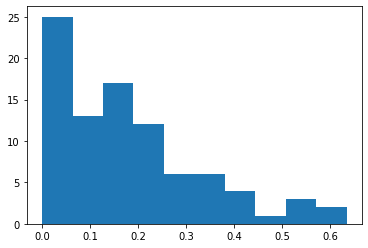

In [87]:
plt.hist(diametererror)

In [88]:
np.mean(np.array(diametererror)[np.array(diametererror)<0.5])

0.15634136753351913

In [89]:
np.mean(np.array(diametererror))

0.17960484752159442

In [90]:
len(np.array(diametererror)[np.array(diametererror)<0.5]),len(diametererror)

(84, 89)

In [91]:
len(TreeDict)

337